In [1]:
import sys

sys.path.append('..')

import decision_transformer.manage as DT_manager
%matplotlib ipympl

cpu


In [2]:
# Simulation configuration
transformer_model_name = 'checkpoint_quad_random_forest_ctgrtg'
from dynamics.quadrotor import dataset_scenario

In [3]:
# Import dataset and dataloader
datasets, dataloaders = DT_manager.get_train_val_test_data(mdp_constr=True, dataset_scenario=dataset_scenario, timestep_norm=False)
train_dataset, val_dataset, test_dataset = datasets
train_loader, eval_loader, test_loader = dataloaders


Loading data from root/dataset/random_target_forest/torch/...Completed, DATA IS NOT SHUFFLED YET.



In [4]:
# Get the model and set it into eval mode
model = DT_manager.get_DT_model(transformer_model_name, train_loader, eval_loader)
model.eval()

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


GPT size: 11.1M parameters


AutonomousQuadTransformer(
  (encoder): DecisionTransformerGPT2Model(
    (wte): Embedding(1, 384)
    (wpe): Embedding(1024, 384)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x DecisionTransformerGPT2Block(
        (ln_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): DecisionTransformerGPT2Attention(
          (c_attn): Conv1D(nf=1152, nx=384)
          (c_proj): Conv1D(nf=384, nx=384)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): DecisionTransformerGPT2MLP(
          (c_fc): Conv1D(nf=1536, nx=384)
          (c_proj): Conv1D(nf=384, nx=1536)
          (act): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (embed_timestep): Embedding(100, 384)
  (embed_goal): Linea

In [5]:
# Sample from test dataloader
data_stats = test_loader.dataset.data_stats
test_sample = next(iter(test_loader))# <- deterministic sample OR random sample -> next(iter(test_loader))#
states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, time_discr_i, time_sec_i, ix_i = test_sample
x_init = (states_i[0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])
x_final = (goal_i[0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])


/home/evelasco11/data/miniconda3/envs/Research/lib/python3.13/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
# Use the model just to perform imitation learning
print(test_sample[-1])
DT_trajectory,_ = DT_manager.use_model_for_imitation_learning(model, train_loader, test_sample, rtg_perc= 1., ctg_perc=1., use_dynamics=True, output_attentions=True)

tensor([[17482]])


/data/evelasco11/transformermpc-ral24/drone/decision_transformer/../decision_transformer/manage.py:498: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_ol = torch.cat((states_ol, torch.tensor(state_preds_ol[:, t][None,:,:]).to(device)), dim=1).float()


tensor([[17482]])


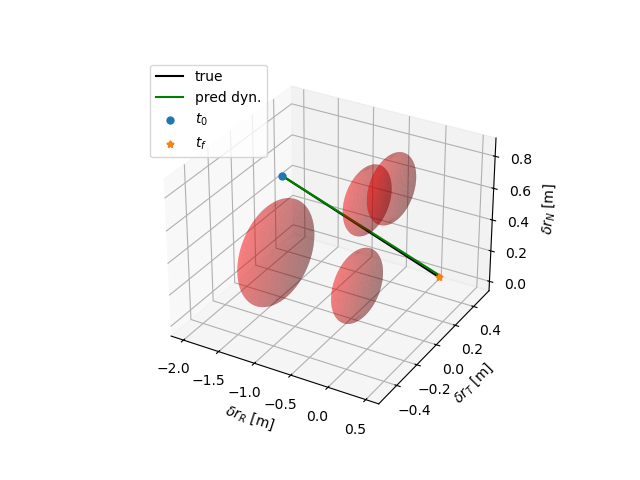

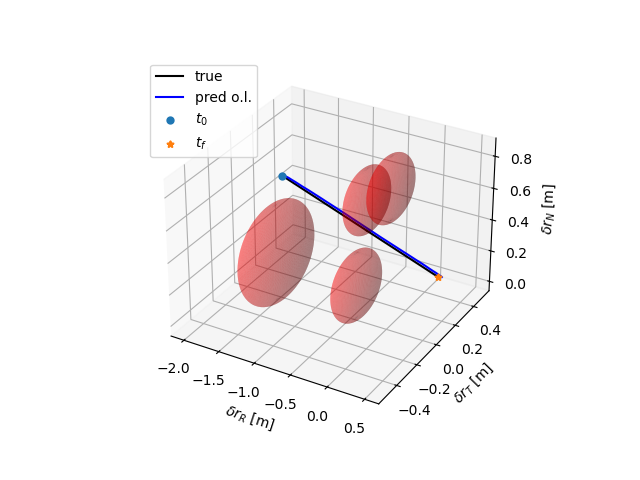

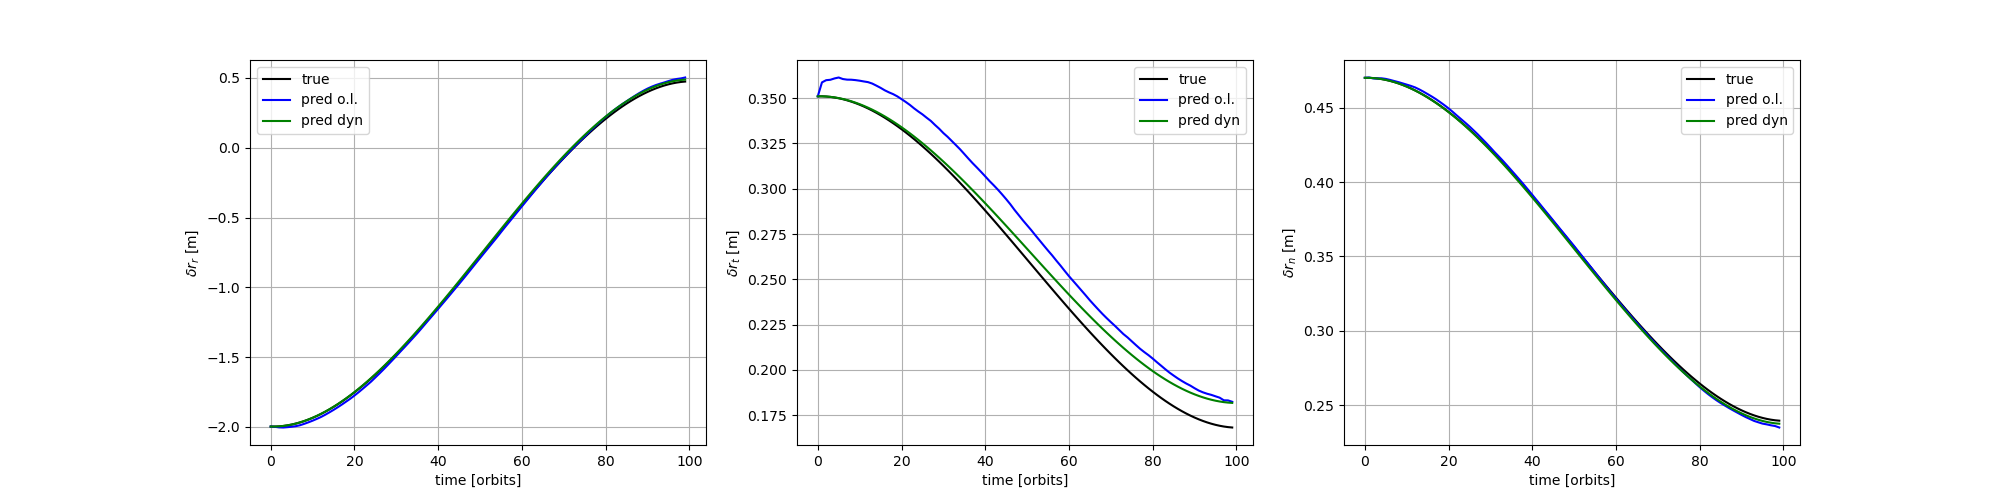

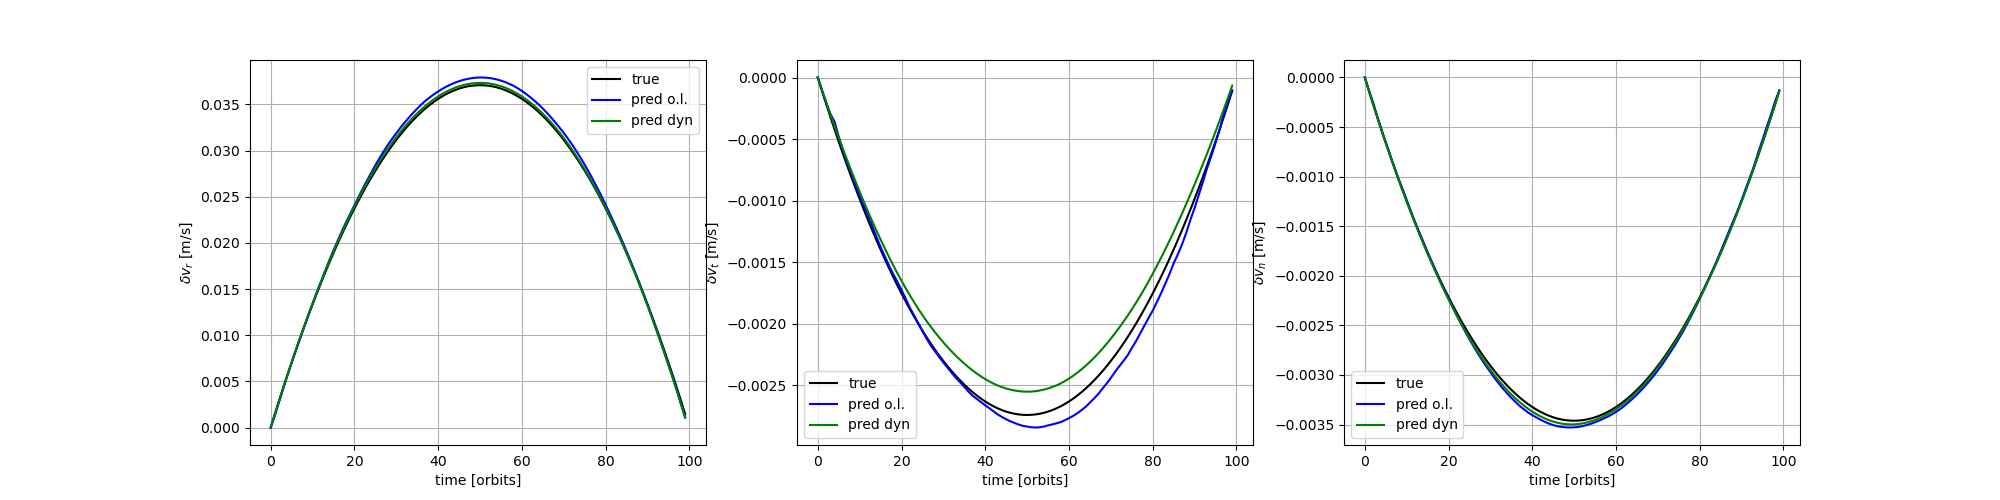

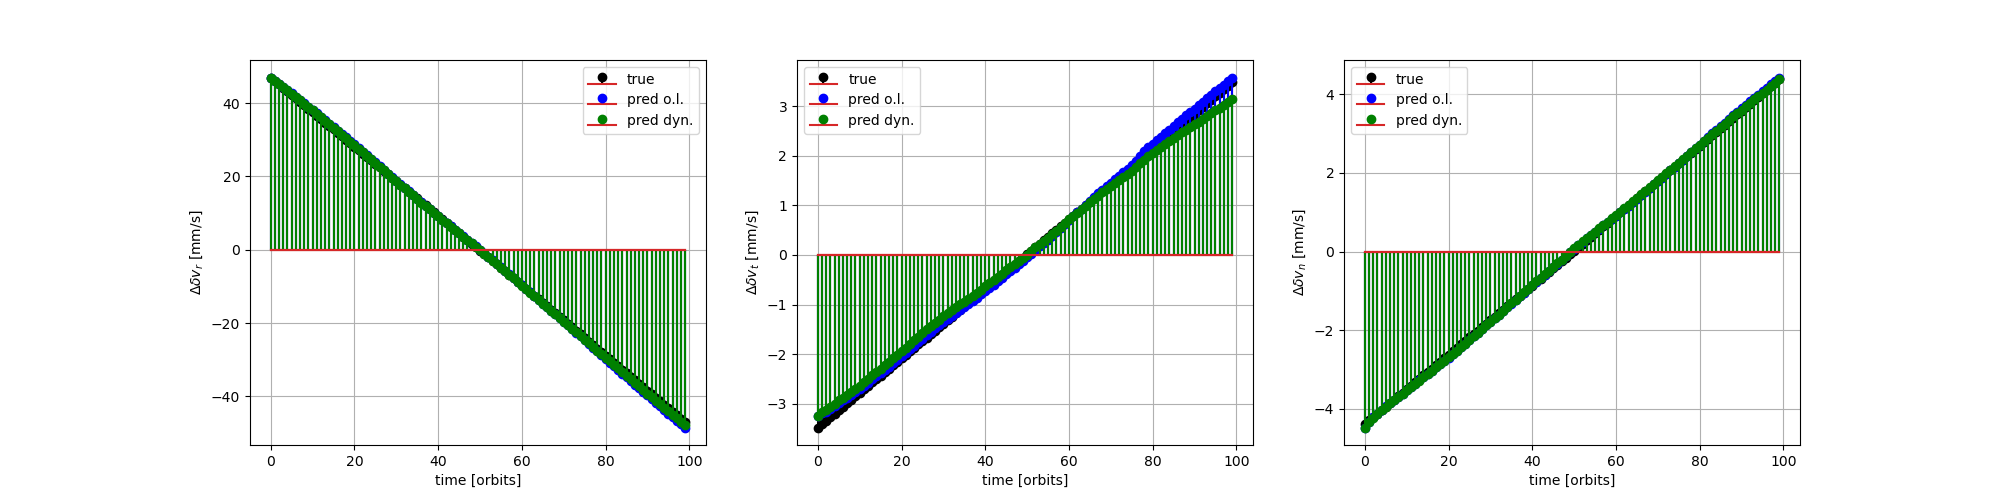

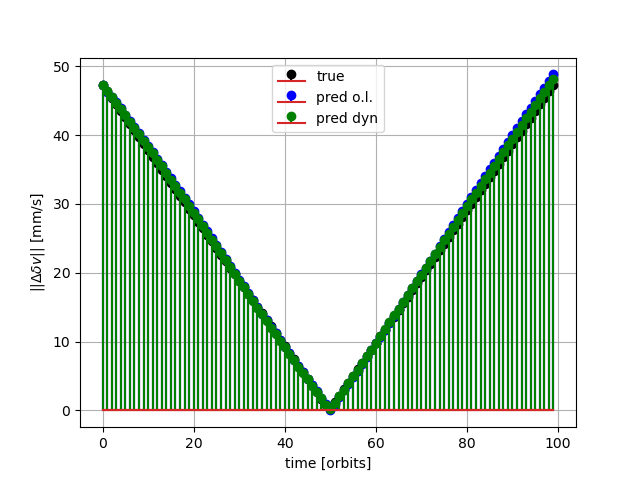

In [7]:
# Print the index of the trajectory and plot
print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

In [8]:
# Use the model to perform offline RL
# Take the desired rtg0 from convex problem
from dynamics.quadrotor import *
qm = QuadModel(verbose=True)
xs, us, J, status = ocp_no_obstacle_avoidance(qm,x_init,x_final,initial_guess='line')
rtg_0 = -np.sum((np.linalg.norm(us.T, axis=0))**2)/2

# Use the model (open-loop / dyn-in-the-loop)
ol_trajectory, runtime_DT = DT_manager.torch_model_inference_ol(model, test_loader, test_sample, ctg_perc=0., rtg=rtg_0, ctg_clipped=True)
dyn_trajectory, runtime_DT = DT_manager.torch_model_inference_dyn(model, test_loader, test_sample, ctg_perc=0., rtg=rtg_0, ctg_clipped=True)

Initializing drone class.
optimal
optimal
optimal


In [ ]:
# Print the index of the trajectory and plot
DT_trajectory = {
    'xyz_true' : ((states_i[0,:,:].cpu() * data_stats['states_std']) + data_stats['states_mean']).T,
    'xyz_dyn' : dyn_trajectory['xyz_dyn'],
    'xyz_ol' : ol_trajectory['xyz_ol'],
    'dv_true' : ((actions_i[0,:,:].cpu() * data_stats['actions_std']) + data_stats['actions_mean']).T,
    'dv_dyn' : dyn_trajectory['dv_dyn'],
    'dv_ol' : ol_trajectory['dv_ol'],
    'time' : ol_trajectory['time']
}
print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

From this point onward -> experimental stuff

In [ ]:
from dynamics.quadrotor import *
x_init = np.array([-1.6807001 ,  0.74334077,  0.02128803, 0., 0., 0.])#-2, -0.20349702,  0.6+0.44711998,  0.       ,  0.       ,         0.])#
x_final = np.array([1.32320872, -0.70945767,  0.91129586, 0., 0., 0.])#1.5, 0.23441744,  0.6+0.56162705,  0.       ,  0.       ,         0.])#
qm = QuadModel(verbose=True)
xs, us, J, status = ocp_no_obstacle_avoidance(qm,x_init,x_final,initial_guess='line')
xs, us, J, status, scp_iter = ocp_obstacle_avoidance(qm, xs, us, x_init, x_final)

In [ ]:
# Sample from test dataloader
data_stats = test_loader.dataset.data_stats
test_sample = next(iter(test_loader))# <- deterministic sample OR random sample -> next(iter(test_loader))#
states_i, actions_i, rtgs_i, ctgs_i, goal_i, timesteps_i, attention_mask_i, time_discr_i, time_sec_i, ix_i = test_sample
x_init = (states_i[0,0,:] * data_stats['states_std'][0]) + (data_stats['states_mean'][0])
x_final = (goal_i[0,0,:] * data_stats['goal_std'][0]) + (data_stats['goal_mean'][0])
#x_init, x_final = sample_init_target()
'''test_sample[0][0,:,:] = (torch.tensor(np.repeat(x_init[None,:], 100, axis=0)) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#(torch.tensor(xs[:-1,:]) - data_stats['states_mean'])/(data_stats['states_std'] + 1e-6)#
test_sample[1][0,:,:] = torch.zeros((100,3))#(torch.tensor(us) - data_stats['actions_mean'])/(data_stats['actions_std'] + 1e-6)#
test_sample[2][0,:,0] = torch.zeros((100,))#torch.from_numpy(compute_reward_to_go(test_sample[1][0,:,:]))#
test_sample[3][:,0] = torch.zeros((100,))#torch.from_numpy(compute_constraint_to_go(test_sample[0][0,:,:].cpu().numpy(), obs_positions, obs_radii))#
test_sample[4][0,:,:] = (torch.tensor(np.repeat(x_final[None,:], 100, axis=0)) - data_stats['goal_mean'])/(data_stats['goal_std'] + 1e-6)'''
print(test_sample[-1])
DT_trajectory,_ = DT_manager.use_model_for_imitation_learning(model, train_loader, test_sample, ctg_perc=0., use_dynamics=True, output_attentions=True)

In [ ]:
model2 = DT_manager.get_DT_model('checkpoint_randt_forest_ctgrtg', train_loader, eval_loader)
model2.eval();
DT_trajectory2,_ = DT_manager.use_model_for_imitation_learning(model2, train_loader, test_sample, ctg_perc=1., use_dynamics=True, output_attentions=True)

In [ ]:
from dynamics.quadrotor import *
qm = QuadModel(verbose=True)
xs, us, J, status = ocp_no_obstacle_avoidance(qm,x_init,x_final,initial_guess='line')
rtg_0 = -np.sum((np.linalg.norm(us.T, axis=0))**2)/2
dyn_trajectory, runtime_DT = DT_manager.torch_model_inference_dyn(model, test_loader, test_sample, rtg_perc=1., ctg_perc=0., rtg=rtg_0, ctg_clipped=True)

In [ ]:
import matplotlib.pyplot as plt
k = 1
plt.figure()
plt.plot(dyn_trajectory['xyz_dyn'][k,:])
plt.plot(DT_trajectory['xyz_dyn'][k,:])
plt.show()

In [ ]:
# Print the index of the trajectory and plot
DT_trajectory['xyz_ol'] = dyn_trajectory['xyz_dyn']
DT_trajectory['dv_ol'] = dyn_trajectory['dv_dyn']
print(test_sample[-1])
DT_manager.plot_DT_trajectory(DT_trajectory)

In [ ]:
dist, viol = check_koz_constraint(dyn_trajectory['xyz_dyn'].T,obs_positions,obs_radii)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dist.T)
plt.plot([0, 100],[0, 0],'r-')
plt.xlabel('time')
plt.ylabel('distance from obstacles')
plt.show()

In [ ]:
states_ws_DT = np.append(dyn_trajectory['xyz_dyn'], (dyn_trajectory['xyz_dyn'][:,-1] + qm.f(dyn_trajectory['xyz_dyn'][:, -1], dyn_trajectory['dv_dyn'][:, -1])*dt).reshape((6,1)), 1).T
xs, us, J, status, scp_iter = ocp_obstacle_avoidance(qm, states_ws_DT, dyn_trajectory['dv_dyn'].T, x_init, x_final)

In [ ]:
xs2, us2, J, status = ocp_no_obstacle_avoidance(qm, x_init, x_final, initial_guess='keep')
print('-----------------')
xs2, us2, J, status, scp_iter = ocp_obstacle_avoidance(qm, xs2, us2, x_init, x_final)

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=10., azim=-20)

ax.scatter(x_init[0], x_init[1], x_init[2], color='k')
ax.scatter(x_final[0], x_final[1], x_final[2], color='k')
#ax.scatter(xs[8,0], xs[8,1], xs[8,2], color='k')

for i in range(n_obs):
    p = obs_positions[i]
    r = obs_radii[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = p[0] + r * np.outer(np.cos(u), np.sin(v))
    y = p[1] + r * np.outer(np.sin(u), np.sin(v))
    z = p[2] + r * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, rstride=1, cstride=1, color='r', linewidth=0, alpha=0.3)
ax.plot3D(xs[:,0], xs[:,1], xs[:,2], color='b', linewidth=1)
ax.plot3D(xs2[:,0], xs2[:,1], xs2[:,2], color='g', linewidth=1)

plt.show()